# 100 Greatest Songs Analysis
In this project I explore the Rolling Stone's top 100 greatest songs of all time!

## Section 1: Import libraries and load/clean data set

In [77]:
import numpy as np 
from itertools import chain
import pandas as pd
import matplotlib.pyplot as plt
import unidecode
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import statistics as st

# Deals with small title differences -> See section 3.5
from difflib import SequenceMatcher
SIM_SCORE = .70

# unicode_escape: Produces a string that is suitable as Unicode literal in Python source code
df = pd.read_csv ('songdata.csv',encoding='unicode_escape')
# This is our set of bad words
badwords = pd.read_csv ('bad_words.csv',encoding='unicode_escape')


## Section 2: Clean our data to make it useable in HTTP request to genius

In [34]:
df = pd.read_csv ('songdata.csv',encoding='unicode_escape',usecols= ['title','artist','released'])

In [10]:
df.head()

,title,artist,released
0,Like a Rolling Stone,Bob Dylan,"July, 1965"
1,(I Can't Get No) Satisfaction',The Rolling Stones,"May, 1965"
2,Imagine,John Lennon,"October, 1971"
3,What's Going On,Marvin Gaye,"Feb, 1971"
4,Respect,Aretha Franklin,"April, 1967"


In [11]:
# A few artists need to have their names adjusted to match genius records
df.at[99,"artist"] = "Grandmaster Flash & the Furious Five"
df.at[32,"artist"] = "Tina Turner"
df.at[38,"artist"] = "Buddy Holly"
df.at[39,"artist"] = "Martha Reeves & the Vandellas"
df.at[149,"artist"] = "Grandmaster Flash & the Furious Five"
df.at[111,"artist"] = "The Mamas & the Papas"
df.at[47,"artist"] = "Simon & Garfunkel"
df.at[48,"artist"] = "Eagles"
df.at[49,"artist"] = "Smokey Robinson & The Miracles"
df.at[84, "artist"] = "Bob Marley & the Wailers"
df.at[94, "artist"] = "Sex Pistols"
df.at[144, "artist"] = "Sex Pistols"
df.at[61,"artist"] = "The Mamas & the Papas"
# A few titles also will not pass the similarity threshold because their genius listings are completely different
df.at[56,"title"] = "Good Golly Miss Molly"
df.at[106,"title"] = "Good Golly Miss Molly"
df.at[79,"title"] = "Papa’s Got a Brand New Bag (Part 1)"

### Only want the top 100 (originally 500)

In [12]:
df = df.truncate(after=99)

In [13]:
df.head()

,title,artist,released
0,Like a Rolling Stone,Bob Dylan,"July, 1965"
1,(I Can't Get No) Satisfaction',The Rolling Stones,"May, 1965"
2,Imagine,John Lennon,"October, 1971"
3,What's Going On,Marvin Gaye,"Feb, 1971"
4,Respect,Aretha Franklin,"April, 1967"


## Section 3: Format our HTTP requests

In [14]:
# Make HTTP requests
import requests
# Scrape data from an HTML document
from bs4 import BeautifulSoup
# I/O
import os
# Search and manipulate strings
import re

GENIUS_API_ACCESS_TOKEN = '5rQGaYZkkiF1WO-wMuFrSR9pMf9xMEpKoF9MZxLvSjhwVPeGobaUAwB89nfFf_d-'

###  Section 3.5: Discovered that the song titles need further cleaning 
There is a big issue I encountered with the data set. Many of the song names do not match their genius listings, which is causing the scraper to get hung. At first, I tried to just manually make the adjustments because I figured there couldn't be that many.... but it turns out there are a lot. So I decided to compute a similarity score between titles instead of direct comparison. This makes it so that if the titles are about 70% similar to each other, they will be counted as the same title.

In [15]:
# Get artist object from Genius API
def request_artist_info(artist_name, page):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + GENIUS_API_ACCESS_TOKEN}
    search_url = base_url + '/search?per_page=10&page=' + str(page)
    data = {'q': artist_name}
    response = requests.get(search_url, data=data, headers=headers)
    return response

In [ ]:
# Get Genius.com song url's from artist object
def request_song_url(artist_name,title):
    page = 1
    url = ""
    
    while True:
        response = request_artist_info(artist_name, page)
        json = response.json()
        # Collect song info
        song_info = []
        for hit in json['response']['hits']:
            if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
                song_info.append(hit)
        # Collect song URL's from song objects, only if title matches what we want
        for song in song_info:
            # Get rid of annoying characters found with repr() function... issue is that the title we pass
            # in from our data frame may not match the song title that appears on genius.
            fix_song = (unidecode.unidecode(song['result']['title'])).replace("'", "")
            fix_song = fix_song.replace(" ","")
            fix_song = re.sub(r'\W+', '', fix_song)
            title = title.replace("'", "")
            title = title.replace(" ", "")
            title = re.sub(r'\W+', '', title)
            # After stripping and removing weirds chars we see if the titles are 70% similar, the reason
            # we cannot simply remove weird chars is because sometimes titles are missing entire phrases 
            # or coordinating conjuctions
            if ((SequenceMatcher(None, fix_song.strip().lower(), title.strip().lower()).ratio()) > SIM_SCORE):
                print(title)
                url = song['result']['url']
        # If we found our song then break and do the next
        if (url != ""):
            break
        # Otherwise keep looking for the song
        else:
            page += 1
            
    return url

## Section 4: Scrape the lyrics!

In [16]:
# Scrape lyrics from a Genius.com song URL
def scrape_song_lyrics(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics = html.find('div', class_="Lyrics__Container-sc-1ynbvzw-6 YYrds").get_text()
    # remove identifiers like chorus, verse, etc
    lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics)        
    return lyrics

### Section 4.5: Add lyrics to our df and save as csv for later use

In [ ]:
for row in range(len(df)):
    # Get the URL
    song_url = request_song_url(df.at[row, "artist"], (df.at[row, "title"]))
    # Set corresponding lyric row to scraped lyrics
    df.at[row,'lyrics'] = scrape_song_lyrics(song_url)

# FOR TESTING 
# song_url = request_song_url("Example Artist", "Example Title")
# lyrics = scrape_song_lyrics(song_url)
# print(song_url)
# print(lyrics)
    

In [81]:
# df.to_csv('/Users/edwardbaker/Desktop/Song Analysis/songs_&_lyrics2.csv')

In [82]:
df =  pd.read_csv('songs_&_lyrics2.csv',encoding='unicode_escape', usecols=['title','artist','released','lyrics'])

In [83]:
df.head()

,title,artist,released,lyrics
0,Like a Rolling Stone,Bob Dylan,"July, 1965",Once upon a time you dressed so fineThrew the ...
1,(I Can't Get No) Satisfaction',The Rolling Stones,"May, 1965",I can't get no satisfactionI can't get no sati...
2,Imagine,John Lennon,"October, 1971",Imagine there's no heavenIt's easy if you tryN...
3,What's Going On,Marvin Gaye,"Feb, 1971","Hey, hey-heyHey, what's happenin'?Hey, brother..."
4,Respect,Aretha Franklin,"April, 1967","What you want, baby, I got itWhat you need, do..."


## Section 5: Reformat the lyrics text
Currently, the spacing is incorrect due to the formatting on genius. How can we identify where one sentence begins and ends with no punctuation? Go through all the words, check to see where we have our captial letters, this well help us split up our sentences. We can do this using regex positive look ahead. We will turn the lyrics into token arrays with the help of NLTK as well.

In [84]:
for i in range(len(df)):
    df.at[i,'lyrics'] = re.split('(?=[A-Z])',df.at[i,'lyrics'])

In [85]:
for i in range(len(df)):
    words = [[]]
    for sent in df.at[i,'lyrics']:
        # word_tokenize sometimes struggles with apostrophe, so lets take care of this
        # it also counts commas and exclamation as words so lets strip those
        sent = re.sub("[',!]", '', str(sent))
        # we don't want to add empty lists
        if sent:
            words.append(word_tokenize(sent))
    # flatten array
    words = list(chain.from_iterable(words))
    df.at[i,'lyrics'] = words

In [86]:
df.head()

,title,artist,released,lyrics
0,Like a Rolling Stone,Bob Dylan,"July, 1965","[Once, upon, a, time, you, dressed, so, fine, ..."
1,(I Can't Get No) Satisfaction',The Rolling Stones,"May, 1965","[I, cant, get, no, satisfaction, I, cant, get,..."
2,Imagine,John Lennon,"October, 1971","[Imagine, theres, no, heaven, Its, easy, if, y..."
3,What's Going On,Marvin Gaye,"Feb, 1971","[Hey, hey-hey, Hey, whats, happenin, ?, Hey, b..."
4,Respect,Aretha Franklin,"April, 1967","[What, you, want, baby, I, got, it, What, you,..."


## Section 6: Analysis!
What kind of interesting questions can we ask about our data?
* At first I thought it would be interesting to see whether songs increased in vulgarity as they increased in year released. However, I did not predict that no songs would contain bad words. You will see this below.

### Descriptive Stats

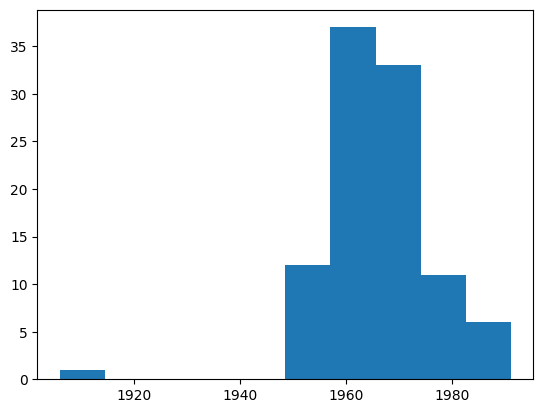

In [87]:
# Lets get our years
years = []

for i in range(len(df)):
    years.append(int(df.at[i,'released'].split(',')[1].strip()))
    
plt.hist(years)
plt.show() 

As we can see above, our songs are almost entirely from the 50s to the 90s.

### More stats...

In [88]:
print("The mean year for greatest song is: " + str(round(st.mean(years))))
print("The median year for greatest song is: " + str(round(st.median(years))))
print("The mode of our years for greatest songs is: " + str(round(st.mode(years))))
print("The range of years for greatest songs is: " + str(min(years)) + " to " + str(max(years)))
print("The std of years for greatest songs is: " + str(st.stdev(years)))
print("The var of years for greatest songs is: " + str(st.variance(years)))



The mean year for greatest song is: 1966
The median year for greatest song is: 1966
The mode of our years for greatest songs is: 1965
The range of years for greatest songs is: 1906 to 1991
The std of years for greatest songs is: 10.015422450834857
The var of years for greatest songs is: 100.30868686868688


## Q1: Is vulgarity postively correlated with year released?

#### Cleaning our bad words and making a set

In [89]:
bws = set()

for i in range(len(badwords)):
    badwords.at[i,'a55,'] = re.sub("[,*]", '', str(badwords.at[i,'a55,']))
    bws.add(badwords.at[i,'a55,'])

### Vulgarity Score
Each song is given a vulgarity score defined as $$ V = \frac {\sum_{i}^{}B_i}{|W|} $$
* $$ B = Badwords, W = words $$

In [90]:
for i in range(len(df)):
    vulgarity_score = 0
    bwc = 0
    for lyric in df.at[i,'lyrics']:
        if lyric in badwords:
            bwc += 1
    vulgarity_score = bwc / len(df.at[i,'lyrics'])
    df['vulgarity_score'] = vulgarity_score

In [91]:
df.head()

,title,artist,released,lyrics,vulgarity_score
0,Like a Rolling Stone,Bob Dylan,"July, 1965","[Once, upon, a, time, you, dressed, so, fine, ...",0.0
1,(I Can't Get No) Satisfaction',The Rolling Stones,"May, 1965","[I, cant, get, no, satisfaction, I, cant, get,...",0.0
2,Imagine,John Lennon,"October, 1971","[Imagine, theres, no, heaven, Its, easy, if, y...",0.0
3,What's Going On,Marvin Gaye,"Feb, 1971","[Hey, hey-hey, Hey, whats, happenin, ?, Hey, b...",0.0
4,Respect,Aretha Franklin,"April, 1967","[What, you, want, baby, I, got, it, What, you,...",0.0


In [92]:
for i in range(len(df)):
    if df.at[i,'vulgarity_score'] > 0.0:
        print(df.at[i,'title'])

###  Q1 results: Suprisingly, none of these songs have bad words!
Potential explanation: 

## Q2: How many songs discuss love?

In [93]:
love_words = {'love', 'loving', 'loved', 'lover', 'loves', 'lovers','lovely','lovingly'}

In [100]:
love_songs = set()

for i in range(len(df)):
    lwc = 0
    love_score = 0
    for lyric in df.at[i,'lyrics']:
        if lyric in love_words:
            lwc += 1
            love_songs.add(df.at[i,'title'])
    love_score = (lwc / len(df.at[i,'lyrics']))
    df.at[i,'love_score'] = love_score

print(str(len(love_songs)) + " out of 100 songs discuss love")

39 out of 100 songs discuss love


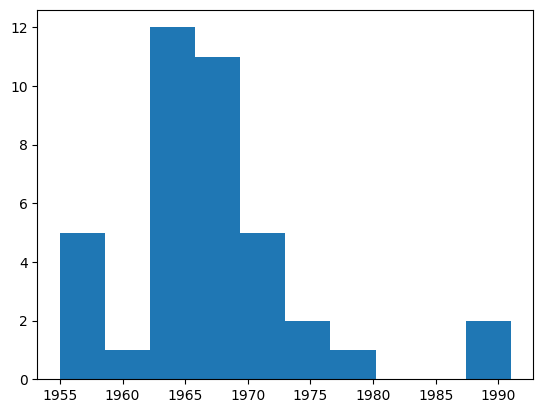

The mean year for love song is: 1967
The median year for love song is: 1966
The mode of our years for love songs is: 1965
The range of years for love songs is: 1955 to 1991
The std of years for love songs is: 7.702988536189312
The var of years for love songs is: 59.336032388663966


In [107]:
# Lets get our years
years = []

for i in range(len(love_songs)):
    years.append(int(df.at[i,'released'].split(',')[1].strip()))
    
plt.hist(years)
plt.show()

print("The mean year for love song is: " + str(round(st.mean(years))))
print("The median year for love song is: " + str(round(st.median(years))))
print("The mode of our years for love songs is: " + str(round(st.mode(years))))
print("The range of years for love songs is: " + str(min(years)) + " to " + str(max(years)))
print("The std of years for love songs is: " + str(st.stdev(years)))
print("The var of years for love songs is: " + str(st.variance(years)))

### Making a plot

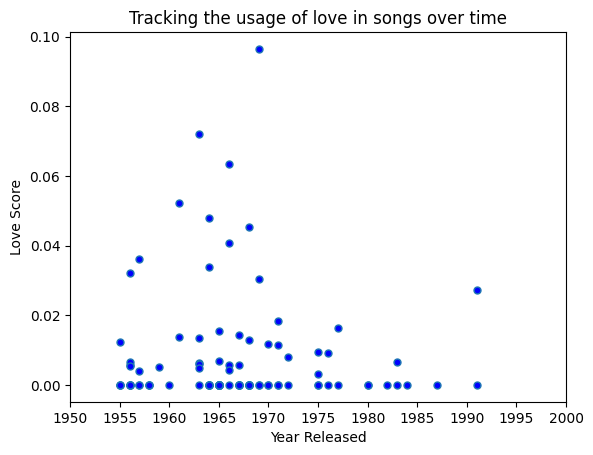

In [104]:
# Lets get our x and y
coordinates = [()]

for i in range(len(df)):
    coordinate = (int(df.at[i,'released'].split(',')[1].strip()), df.at[i,'love_score'])
    coordinates.append(coordinate)

# Unpack our list of tuples into x,y lists
# First entry is empty, need to investigate why
coordinates = coordinates[1:]
x, y = zip(*coordinates)

# plotting the points 
plt.plot(x, y,linestyle='None',
         marker='o', markerfacecolor='blue', markersize=5)

# setting x and y axis range
plt.xlim(1950,2000)
plt.xticks([1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,2000])
  
# naming the x axis
plt.xlabel('Year Released')
# naming the y axis
plt.ylabel('Love Score')
  
# giving a title to my graph
plt.title('Tracking the usage of love in songs over time')

# function to show the plot
plt.show()

###  Q2 results:
* What we can learn is that: Love songs are very common, accounting for 39% of all songs on our list.
* We cannot really determine if love songs are positively correlated with year released given our small amount of data
* The most common year for love song is 1965, but that is also just the most common year for songs on our list so that doesn't really tell us much.


## Conclusion and whats next?
To extend this project further there needs to be a larger data set so that we can draw more insightful conclusions. I would also like to try and do a similar project but perhaps for a particular artist.